# Problema 2:
Determine la deformación y los esfuerzos principales en función de la posición para una chapa con
un agujero en el centro sujeta a tracción por sus extremos, como se muestra en la figura. Las
dimensiones de la chapa son de 20 x 10 pulgadas y su espesor de una pulgada. El radio del agujero
central es también de 1 pulgada. Tome E = 30 x 106
 psi y n = 0.30.
Analice el problema con número creciente de elementos y estudie su convergencia

Aprovechando la simetría del ejercicio, se simula un cuarto de la pieza:

                                           l2
                                  p4------------------p3
                                   l                   l
                               l1  l           S       l
            Empotrado              l                   l    l3     Traccionado
                                  p5------\            l
                                   l      l            l
                                   p1----p6------------p2 
                                               l4


In [1]:
import gmsh
import numpy as np
import copy
    
GL = 2     # Grados de libertad
E = 30e6   # psi Modulo de elasticidad
v = 0.3    # Módulo de Poisson
T = 1000   # Tensión de tracción

In [2]:
gmsh.initialize()           # Inicializo
gmsh.model.add('ej2')       # Agrego el modelo del ejercicio

# Defino entidades geométricas

Definición de puntos

In [3]:
# Sección rectangular

lc = 1                                       # Refinamiento del mallado
H = 5                                        # Alto en pulgadas
L = 10                                       # Largo en pulgadas
Es = 1                                       # Espesor en pulgadas
p1 = gmsh.model.geo.addPoint(0, 0, 0, lc)
p2 = gmsh.model.geo.addPoint(L, 0, 0, lc) 
p3 = gmsh.model.geo.addPoint(L, H, 0, lc) 
p4 = gmsh.model.geo.addPoint(0, H, 0, lc) 

# Sección circular central (Agujero)

r = 1                                        # Radio en pulgadas
la = lc/5                                     # Refinamiento del mallado cerca del círculo
p5 = gmsh.model.geo.addPoint(0, r, 0, la)
p6 = gmsh.model.geo.addPoint(r, 0, 0, la)

Definición de lineas entre los puntos y las uno para formar las curvas

In [4]:
# Sección llena

l1 = gmsh.model.geo.addLine(p5, p4)
l2 = gmsh.model.geo.addLine(p4, p3)
l3 = gmsh.model.geo.addLine(p3, p2)
l4 = gmsh.model.geo.addLine(p2, p6)
# semi = gmsh.model.geo.addCircleArc(p6,p1,p5) 

Rect = gmsh.model.geo.addCurveLoop([l1, l2, l3, l4])
#Rect = gmsh.model.geo.addCurveLoop([l1, l2, l3, l4, semi])

# Semicírculo en una esquina

semi = gmsh.model.geo.addCircleArc(p5,p1,p6)

Circ = gmsh.model.geo.addCurveLoop([semi])

* Determino la superficie rectancular descontando el círculo
* Sincronizo los elementos geométricos

In [5]:
S = gmsh.model.geo.addPlaneSurface([Rect, Circ])
#S = gmsh.model.geo.addPlaneSurface([Rect])
gmsh.model.geo.synchronize()

# Condiciones de contorno: defino los grupos físicos

**Cortes de simetría:** 
el material existente del otro lado impediría su movimiento en dicha dirección → solo movimiento longitudinal: empotramientos

In [6]:
EmpX = gmsh.model.addPhysicalGroup(1, [l4])     # Linea en X con empotramiento en Y
gmsh.model.setPhysicalName(1,EmpX, "EmpX")

EmpY = gmsh.model.addPhysicalGroup(1, [l1])     # Linea en Y con empotramiento en X
gmsh.model.setPhysicalName(1,EmpY, "EmpY")

**Traccionados**

In [7]:
Trac = gmsh.model.addPhysicalGroup(1, [l3])
gmsh.model.setPhysicalName(1,Trac,'Trac')

**Superficie**

In [8]:
Sup = gmsh.model.addPhysicalGroup(2,[S])
gmsh.model.setPhysicalName(2, Sup, 'Sup')

**Eliminación del punto 1 auxiliar**

In [56]:
trash = gmsh.model.addPhysicalGroup(0, [p1])
gmsh.model.setPhysicalName(0,trash, "trash")

Generación del mallado indicando su dimensión

In [10]:
gmsh.model.geo.synchronize()

In [11]:
gmsh.model.mesh.generate(2)

Extracción de datos de mallado generado

In [12]:
# Nodos

nodos = gmsh.model.mesh.get_nodes()      # Información de los nodos del mallado
#nodos[1].shape
N = nodos[0].shape[0]                    # Número de nodos
MN = nodos[1].reshape(N , 3)             # Matriz de nodos

# Elementos

e_tags, e = gmsh.model.mesh.get_elements_by_type(2)  # Información de los elementos tipo 2 (triangulares)
MC = e.reshape([e_tags.shape[0],3])                  # Matriz de conectividad

# Traccionados

ent_trac = gmsh.model.getEntitiesForPhysicalGroup(1, Trac)      # Entidad de elementos traccionados
t1, t2, long_trac = gmsh.model.mesh.getElements(1, ent_trac[0]) 
Long_trac = long_trac[0].reshape(t2[0].shape[0],2)  # Nodos de cada elemento de la entidad

Calculo las **fuerzas** conocidas sobre cada elemento del grupo físico traccionado "Trac"

In [13]:
F = np.zeros((2*N, 1))

for i, line in enumerate(Long_trac):
    n1 = int(line[0]-1)
    n2 = int(line[1]-1)
    long = np.abs(MN[n1,1]-MN[n2,1])
    Floc = (T * long * Es)/2 * np.array([[1],[1]])
    F[ np.array([2*n1, 2*n2]) ] += Floc
    
Fx = F[::2]; Fy = F[1::2]

Obtengo los nodos del mallado correspondientes a cada grupo físico

In [14]:
Nx_emp = gmsh.model.mesh.get_nodes_for_physical_group(1,EmpX)
Ny_emp = gmsh.model.mesh.get_nodes_for_physical_group(1,EmpY)
NTri = gmsh.model.mesh.get_nodes_for_physical_group(2,Sup)      # Nodos de los triangulos
NTrash = gmsh.model.mesh.get_nodes_for_physical_group(0,trash)

**Grafico** del mallado y sus respectivos grupos físicos.

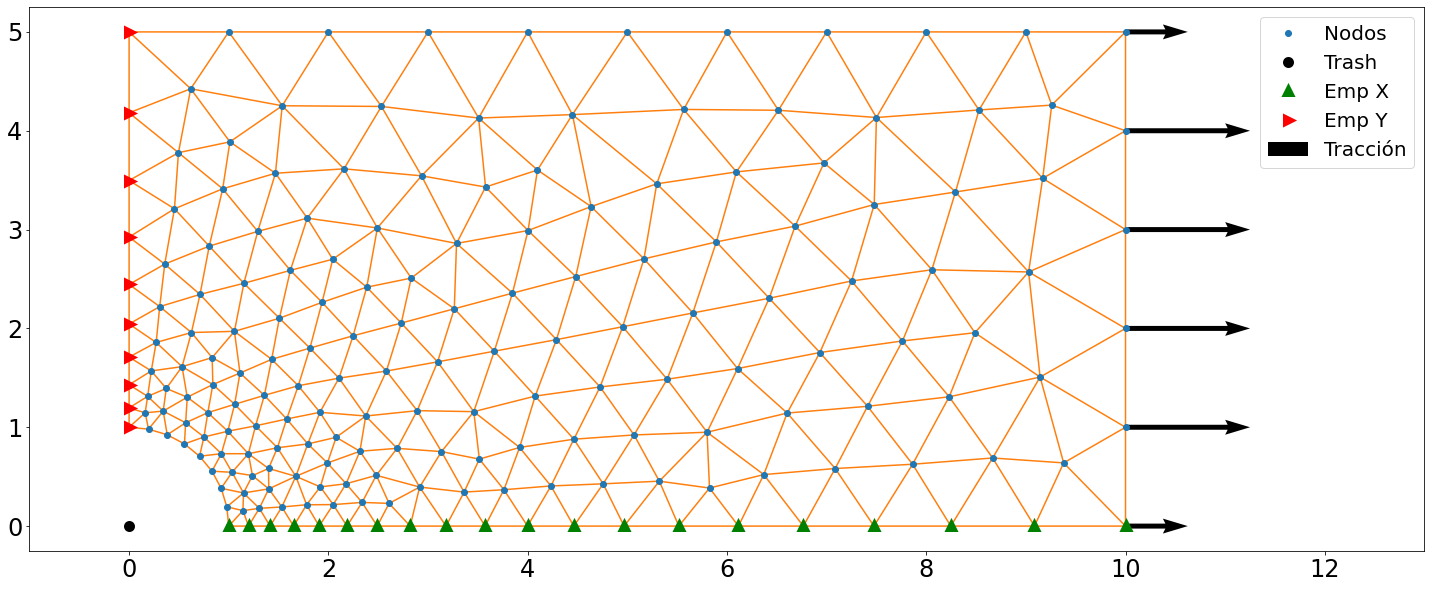

In [15]:
import matplotlib.pyplot as plt
plt.rc('figure', figsize=(25,10))
plt.rc('axes', labelsize=24 )
plt.rc('xtick', labelsize=24 )
plt.rc('ytick', labelsize=24 )
plt.rc('legend', fontsize=20)
plt.xlim([-1, L+3])

plt.plot(MN[NTri[0]-1, 0], MN[NTri[0]-1,1], 'o', label='Nodos')
plt.triplot(MN[NTri[0]-1, 0], MN[NTri[0]-1, 1], MC-MC.min())
plt.plot(MN[NTrash[0]-1, 0], MN[NTrash[0]-1, 1,], "ko", markeredgewidth=5, label="Trash")
plt.plot(MN[Nx_emp[0]-1, 0], MN[Nx_emp[0]-1, 1], "g^", markeredgewidth=5, label='Emp X')
plt.plot(MN[Ny_emp[0]-1, 0], MN[Ny_emp[0]-1, 1], "r>", markeredgewidth=5, label='Emp Y' )
plt.quiver(MN[Long_trac[::2].reshape(len(Long_trac)+1,1)-1, 0], MN[Long_trac[::2].reshape(len(Long_trac)+1,1)-1, 1],  Fx[Long_trac[::2].reshape(len(Long_trac)+1,1)[:,0]-1], Fy[Long_trac[::2].reshape(len(Long_trac)+1,1)[:,0]-1],scale=800, units="x", width=0.05, label='Tracción')

plt.legend()

Defino los vectores de nodos de **fuerzas (r)** y de **desplazamientos (s)** conocidos

In [16]:
s = np.hstack(
    [   2*(Nx_emp[0]-1)+1,
        2*(Ny_emp[0]-1),                 # Nx_emp = arista horizontal → desplazamiento en Y = 0
        2*(NTrash[0]-1),                 # Ny_emp = arista vertical → desplazamiento en X = 0  
        2*(NTrash[0]-1)+1 ])

r = np.delete( np.arange(2*N) , s )

Cálculo de la **matriz de rigidez**

In [17]:
el = len(MC)      # cantidad de elementos
K = np.zeros([N*GL, N*GL])
Bs=[]
D = (E/(1-(v**2)))*np.array([[1,v,0],[v,1,0],[0,0,(1-v)/2]])
for a in range(el):     # Recorro los triangulos
    B = np.zeros([3,6])
    c = []              #coordenadas de los nodos del elemento
    for i in MC[a]:
        aux=MN[int(i-1)].copy()
        aux[2]=1
        c.append(aux)
    b=[0,0,0]
    g=[0,0,0]
    A = np.linalg.det(c)/2           # Probar sin un menos
    for d in range(3): 
        b[d] = c[d-2][1]- c[d-1][1]
        g[d] = c[d-1][0]- c[d-2][0]
    for j in range(3):
        B0=[[b[j],0],[0, g[j]], [g[j], b[j]]]
        B[0][j*2]=b[j]
        B[1][2*j+1]=g[j]
        B[2][j*2]=g[j]
        B[2][j*2+1]=b[j]
    B = B/(2*A)
    Bs.append(B)
    k = Es*abs(A)*np.dot(B.transpose(), np.dot(D,B) )
    for i in range(3):
        nx=int(MC[a][i]-1)
        for j in range(3):
            ny=int(MC[a][j]-1)
            K[np.ix_([nx*2,nx*2+1], [ny*2,ny*2+1])]+=k[i*2:i*2+2, j*2:j*2+2]

Calculo los **desplazamientos y fuerzas finales**

In [18]:
d = np.zeros(N*GL)
f = np.zeros(N*GL)

dd = np.linalg.solve(K[np.ix_(r,r)], F[r])  # Desplazamientos resultantes

d[r]=dd.ravel()

Ffinal=K.dot(d)   # Fuerzas resultantes
B=np.array(B)
D=np.array(D)

**Grafico** las fuerzas y desplazamientos resultantes (aplicadas y reacciones)

In [19]:
Dx = d[::2]; Dy = d[1::2]
Ffx = Ffinal[::2]; Ffy = Ffinal[1::2]

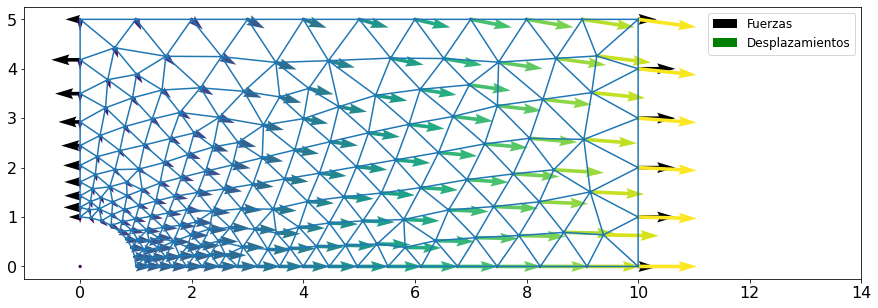

In [55]:
plt.rc('figure', figsize=(15,5))
plt.rc('axes', labelsize=24 )
plt.rc('xtick', labelsize=16 )
plt.rc('ytick', labelsize=16 )
plt.rc('legend', fontsize=12)
plt.triplot(MN[NTri[0]-1, 0], MN[NTri[0]-1, 1], MC-MC.min())
plt.xlim([-1, L+4])
plt.quiver(MN[1:,0], MN[1:,1], Ffx[1:], Ffy[1:], units='x',scale=1500, label="Fuerzas")
plt.quiver(MN[:,0], MN[:,1], Dx, Dy, Dx, scale=0.005, color="g", label="Desplazamientos")
plt.legend()

> Los desplazamientos aumentan al llegar a la superficie traccionada. Además, se producen reacciones de las fuerzas aplicadas, en la dirección opuesta a las mismas.

Calculo los **esfuerzos resultantes** de la solicitación

In [21]:
Esf=[]
for i in range(len(MC)):
    jj=np.array(MC[i]-1)*2 
    index=[jj[0],jj[0]+1,jj[1],jj[1]+1,jj[2],jj[2]+1]
    Esf.append( np.dot( np.dot(D,Bs[i]), d[np.array(index,  dtype=int)])) 
Esf=np.array(Esf)

In [22]:
T_max = (Esf[:,0]+Esf[:,1])/2 + np.sqrt(((Esf[:,0]+Esf[:,1])**2)/4 + Esf[:,2]**2)
# T_max = (Esf[:,0]+Esf[:,1])/2 + np.sqrt(((Esf[:,0]**2+(Esf[:,1])**2)/4 + Esf[:,2]**2))

(-0.5, 10.5)

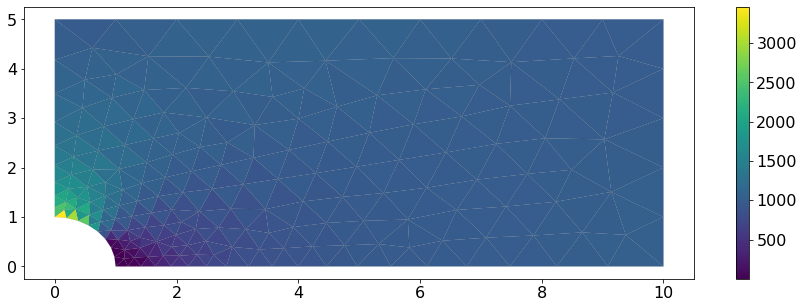

In [23]:
fig, ax = plt.subplots(1,1, figsize=(15,5))
cmap = ax.tripcolor(MN[NTri[0]-1,0],MN[NTri[0]-1,1],MC-MC.min(), facecolors=T_max, edgecolor='k',linewidth=0.05)
cbar = plt.colorbar(cmap)
ax.set_xlim([-0.5,L+0.5])

> Se observa que las tensiones se concentraron en el agujero en la direccion perpendicular a la tracción.

**Fin**

--**_Aguante física_**--